# ETL (Part 1) Loading the survey raw data into a database using SQLite

In [356]:
# Import dependencies
import pandas as pd
import sqlite3
from tabulate import tabulate 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from wordcloud import STOPWORDS
import re

In [357]:
# Define the path to the CSV file
survey_raw_data = 'data/survey.csv'

In [358]:
# Load the CSV data into a DataFrame
survey_raw_df = pd.read_csv(survey_raw_data)

## Cleanup the columns

### Clean up column[Gender]

In [359]:
survey_raw_df['Gender'] = survey_raw_df['Gender'].str.strip()
survey_raw_df['Gender'] = survey_raw_df['Gender'].str.lower()

male_variations = ['male', 'm', 'maile', 'cis male', 'mal', 'male (cis)', 'make', 'man', 'msle', 'mail', 'malr', 'cis man']
female_variations = ['female', 'f', 'cis female', 'woman', 'femake', 'female (cis)', 'femail']

for male_variation in male_variations:
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(male_variation, 'M')

for female_variation in female_variations:
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(female_variation, 'F')


### Determine remaining values in Gender column

In [360]:
remaining = survey_raw_df[survey_raw_df['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head(50)

14


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
72,2014-08-27 11:54:27,23,trans-female,United States,MA,No,No,No,Rarely,More than 1000,...,Somewhat difficult,Maybe,No,Yes,Yes,No,No,No,No,NaN
306,2014-08-27 14:22:36,30,queer,United States,IL,No,Yes,Yes,Rarely,26-100,...,Somewhat easy,Maybe,No,Some of them,Yes,No,No,Don't know,No,NaN
349,2014-08-27 14:47:28,25,non-binary,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
387,2014-08-27 15:24:22,29,non-binary,United States,CA,Yes,Yes,Yes,Sometimes,1-5,...,Very difficult,Yes,No,Some of them,No,No,Maybe,No,No,NaN
412,2014-08-27 15:30:51,31,non-binary,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Yes,Maybe,No,No,No,Yes,Yes,No,NaN
415,2014-08-27 15:31:20,30,non-binary,Germany,NaN,No,Yes,Yes,Sometimes,100-500,...,Somewhat difficult,No,No,Yes,Yes,Maybe,Maybe,No,No,In Germany your employer doesn't really provide mental health benefits. There's a standard and I get that but I would get the same at any other company in Germany.
450,2014-08-27 15:53:59,40,queer,United States,VA,No,Yes,No,Never,More than 1000,...,Don't know,Yes,Maybe,No,Some of them,No,Maybe,Yes,No,NaN
543,2014-08-27 18:13:38,28,non-binary,United Kingdom,NaN,No,Yes,Yes,Rarely,100-500,...,Somewhat difficult,Yes,Yes,Some of them,Some of them,Yes,No,No,Yes,I bring up my depression in interviews solely because I have a large gap on my CV due to mental health issues which could be mistaken for a gap taken to say have children which I feel would harm my chances much more. I have other MH issues I would never bring up with employers or peers.
552,2014-08-27 18:56:46,21,non-binary,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat easy,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
681,2014-08-28 09:02:16,19,trans-female,United States,MO,No,Yes,Yes,Often,26-100,...,Somewhat difficult,Maybe,Maybe,No,No,No,Maybe,No,No,NaN


### Abbreviate genders

In [361]:
gender_abbreviations = {
    "trans-female"  : "TF",
    "trans-male"    : "TM",
    "queer"         : "Q",
    "non-binary"    : "NB"
}

for gender_name, gender_abbreviation in gender_abbreviations.items():
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(gender_name, gender_abbreviation)

survey_raw_df.head()


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,M,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Verify data in Gender columns are correctly abbreviated

In [362]:
remaining = survey_raw_df[survey_raw_df['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head(20)

14


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
72,2014-08-27 11:54:27,23,TF,United States,MA,No,No,No,Rarely,More than 1000,...,Somewhat difficult,Maybe,No,Yes,Yes,No,No,No,No,NaN
306,2014-08-27 14:22:36,30,Q,United States,IL,No,Yes,Yes,Rarely,26-100,...,Somewhat easy,Maybe,No,Some of them,Yes,No,No,Don't know,No,NaN
349,2014-08-27 14:47:28,25,NB,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
387,2014-08-27 15:24:22,29,NB,United States,CA,Yes,Yes,Yes,Sometimes,1-5,...,Very difficult,Yes,No,Some of them,No,No,Maybe,No,No,NaN
412,2014-08-27 15:30:51,31,NB,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Yes,Maybe,No,No,No,Yes,Yes,No,NaN
415,2014-08-27 15:31:20,30,NB,Germany,NaN,No,Yes,Yes,Sometimes,100-500,...,Somewhat difficult,No,No,Yes,Yes,Maybe,Maybe,No,No,In Germany your employer doesn't really provide mental health benefits. There's a standard and I get that but I would get the same at any other company in Germany.
450,2014-08-27 15:53:59,40,Q,United States,VA,No,Yes,No,Never,More than 1000,...,Don't know,Yes,Maybe,No,Some of them,No,Maybe,Yes,No,NaN
543,2014-08-27 18:13:38,28,NB,United Kingdom,NaN,No,Yes,Yes,Rarely,100-500,...,Somewhat difficult,Yes,Yes,Some of them,Some of them,Yes,No,No,Yes,I bring up my depression in interviews solely because I have a large gap on my CV due to mental health issues which could be mistaken for a gap taken to say have children which I feel would harm my chances much more. I have other MH issues I would never bring up with employers or peers.
552,2014-08-27 18:56:46,21,NB,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat easy,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
681,2014-08-28 09:02:16,19,TF,United States,MO,No,Yes,Yes,Often,26-100,...,Somewhat difficult,Maybe,Maybe,No,No,No,Maybe,No,No,NaN


### Filter Column['Age']

In [363]:
min_age = 0
max_age = 120
survey_raw_df = survey_raw_df[(survey_raw_df['Age'] >= min_age) & (survey_raw_df['Age'] <= max_age)]

### Clean up timestamp
1. Rename Timestamp to survey_date
2. Remove time - just keep date

In [364]:
survey_raw_df = survey_raw_df.rename(columns={'Timestamp': 'survey_date'})
survey_raw_df['survey_date'] = pd.to_datetime(survey_raw_df['survey_date']).dt.date
survey_raw_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Create company size column

In [365]:
survey_raw_df['company_size'] = survey_raw_df['no_employees']
size_names = {
    "1-5"               : "Small",
    "6-25"              : "Small",
    "26-100"            : "Medium",
    "100-500"           : "Medium",
    "500-1000"          : "Large",
    "More than 1000"    : "Large"
}

for no_of_employees, size_name in size_names.items():
    survey_raw_df['company_size'] = survey_raw_df['company_size'].replace(no_of_employees, size_name)

survey_raw_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,company_size
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,Small
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,NaN,Large
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,NaN,Small
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN,Medium
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN,Medium


## Test if research question can now be answered

In [366]:
survey_data_tech_workers = survey_raw_df[survey_raw_df['tech_company'] == 'Yes']
num_of_tech_workers = len(survey_data_tech_workers)

num_tw_with_mh_issues = survey_data_tech_workers[survey_data_tech_workers['mental_health_consequence'] == 'Yes']
num_tw_with_mh_issues = len(num_tw_with_mh_issues)

percentage_with_issues = float(num_tw_with_mh_issues) / float(num_of_tech_workers) * 100
percentage_with_issues = round(percentage_with_issues, 2)
percentage_with_issues

21.62

In [367]:
survey_data_df = survey_raw_df.copy()
survey_data_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,company_size
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,Small
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,NaN,Large
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,NaN,Small
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN,Medium
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN,Medium


## Write to the Database

### Create connection to SQLITE database

In [368]:
# Create a connection to the SQLite database
conn = sqlite3.connect('survey_database.db')
cursor = conn.cursor()

In [369]:
# Define the table name
table_name = "survey_data"

In [370]:
# Create the table in SQLite (replace it if it already exists)
survey_data_df.to_sql(table_name, conn, if_exists='replace', index=False)

1253

In [371]:
# Commit the changes
conn.commit()

In [372]:
# Verify that the data was loaded by querying the table
query = f"SELECT survey_date, Age, Gender, company_size, seek_help, mental_health_consequence FROM survey_data WHERE tech_company = 'Yes';"
result = pd.read_sql_query(query, conn)
result.head()

,survey_date,Age,Gender,company_size,seek_help,mental_health_consequence
0,2014-08-27,37,F,Small,Yes,No
1,2014-08-27,32,M,Small,No,No
2,2014-08-27,31,M,Medium,No,Yes
3,2014-08-27,31,M,Medium,Don't know,No
4,2014-08-27,33,M,Small,Don't know,No


In [373]:
# Close the connection
conn.close()

In [374]:
print(tabulate(result, headers='keys', tablefmt='psql'))

+------+---------------+-------+----------+----------------+-------------+-----------------------------+
|      | survey_date   |   Age | Gender   | company_size   | seek_help   | mental_health_consequence   |
|------+---------------+-------+----------+----------------+-------------+-----------------------------|
|    0 | 2014-08-27    |    37 | F        | Small          | Yes         | No                          |
|    1 | 2014-08-27    |    32 | M        | Small          | No          | No                          |
|    2 | 2014-08-27    |    31 | M        | Medium         | No          | Yes                         |
|    3 | 2014-08-27    |    31 | M        | Medium         | Don't know  | No                          |
|    4 | 2014-08-27    |    33 | M        | Small          | Don't know  | No                          |
|    5 | 2014-08-27    |    35 | F        | Small          | No          | Maybe                       |
|    6 | 2014-08-27    |    39 | M        | Small      

In [375]:
# Connect to the database 
conn = sqlite3.connect('survey_database.db')

In [376]:
# Load data into a DataFrame
query = "SELECT * FROM survey_data;"
df = pd.read_sql_query(query, conn)

In [377]:
# Filter data to only include respondents from the United States and select relevant columns
usa_data = df[df['Country'] == 'United States'][[
   'Age', 'benefits', 'leave', 'seek_help', 'mental_health_consequence', 'phys_health_consequence', 
    'company_size', 'remote_work', 'work_interfere', 'mental_vs_physical', 'comments'
]]

usa_data.head(10)

,Age,benefits,leave,seek_help,mental_health_consequence,phys_health_consequence,company_size,remote_work,work_interfere,mental_vs_physical,comments
0,37,Yes,Somewhat easy,Yes,No,No,Small,No,Often,Yes,None
1,44,Don't know,Don't know,Don't know,Maybe,No,Large,No,Rarely,Don't know,None
4,31,Yes,Don't know,Don't know,No,No,Medium,Yes,Never,Don't know,None
5,33,Yes,Don't know,Don't know,No,No,Small,No,Sometimes,Don't know,None
6,35,No,Somewhat difficult,No,Maybe,Maybe,Small,Yes,Sometimes,Don't know,None
8,42,Yes,Very difficult,No,Maybe,No,Medium,No,Sometimes,No,None
10,31,Don't know,Don't know,No,No,No,Small,Yes,Sometimes,Don't know,None
12,42,Yes,Somewhat difficult,No,Yes,Yes,Medium,No,Sometimes,No,None
13,36,Don't know,Don't know,Don't know,No,No,Large,No,Never,Don't know,I'm not on my company's health insurance which could be part of the reason I answered Don't know to so many questions.
15,29,Yes,Somewhat easy,No,No,No,Medium,No,Rarely,Don't know,I have chronic low-level neurological issues that have mental health side effects. One of my supervisors has also experienced similar neurological problems so I feel more comfortable being open about my issues than I would with someone without that experience.


C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\3070649010.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='mental_vs_physical', data=usa_data, palette='viridis')


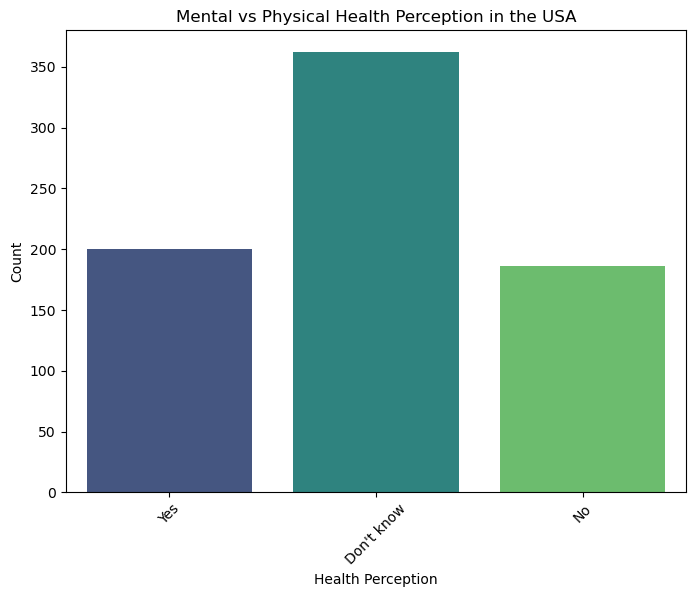

In [378]:
# Generate a visual for mental vs physical health
# Survey Question: Do you feel that your employer takes mental health as seriously as physical health?

plt.figure(figsize=(8, 6))
sns.countplot(x='mental_vs_physical', data=usa_data, palette='viridis')
plt.title('Mental vs Physical Health Perception in the USA')
plt.xlabel('Health Perception')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\806361484.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='company_size', data=usa_data, ax=axs[0, 1], palette="viridis")
C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\806361484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\806361484.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='work_interfere', data=usa_data, ax=axs[1, 1], palette="cividis")


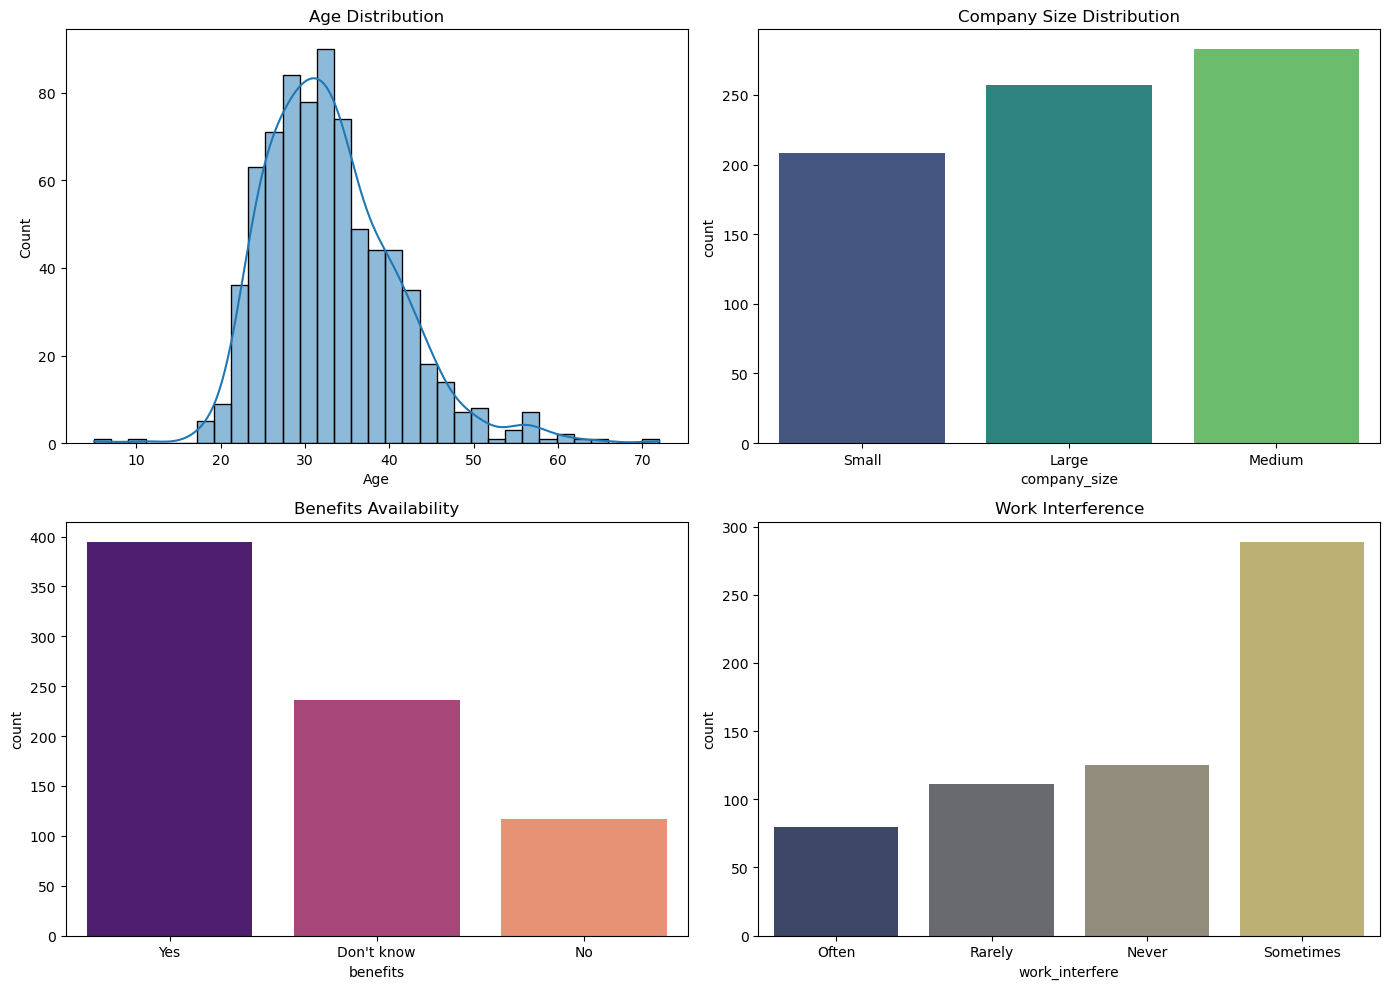

In [379]:
# General exploratory visualization
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plotting distributions of Age
sns.histplot(usa_data['Age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')

# Plotting count of company sizes
sns.countplot(x='company_size', data=usa_data, ax=axs[0, 1], palette="viridis")
axs[0, 1].set_title('Company Size Distribution')

# Plotting count of benefits availability
sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
axs[1, 0].set_title('Benefits Availability')

# Plotting count of work interference
sns.countplot(x='work_interfere', data=usa_data, ax=axs[1, 1], palette="cividis")
axs[1, 1].set_title('Work Interference')

# Adjusting layout
plt.tight_layout()

# Show plot
plt.show()

In [380]:
# Drop rows with None or NaN values in the comments column
usa_comments_df = usa_data.dropna(subset=['comments'])

# Count the number of rows that contain comments from the filtered USA dataset. 
usa_comments = usa_comments_df.shape[0]

# Print the results
print(f"Number of rows with comments: {usa_comments}")

Number of rows with comments: 103


In [381]:
# Combine all comments into one text
comment_text = " ".join(comment for comment in usa_comments_df.comments if isinstance(comment, str))

# Split the comments into individual words
all_words = comment_text.split()

# Define a list of common health-related keywords
health_keywords = [
    "health", "mental", "physical", "stress", "anxiety", "depression", "wellbeing", 
    "therapy", "counseling", "burnout", "pressure", "fatigue", "support", "strain", 
    "illness", "disease", "recovery", "wellness", "treatment"
]

# Count the occurrences of these health-related words in the comments
word_counts = Counter(word.lower() for word in all_words if word.lower() in health_keywords)

# Convert the counter to a DataFrame for better readability
health_word_count_df = pd.DataFrame(word_counts.items(), columns=["Health Related Word", "Frequency"])

# Sort the DataFrame by frequency
health_word_count_df = health_word_count_df.sort_values(by="Frequency", ascending=False)

# Display the table
print(health_word_count_df)

   Health Related Word  Frequency
1               mental         71
0               health         70
3           depression          8
4              anxiety          8
7              illness          7
9            treatment          6
6              support          5
5              therapy          4
8             physical          4
2             wellness          3
11          counseling          2
10             burnout          1
12              stress          1


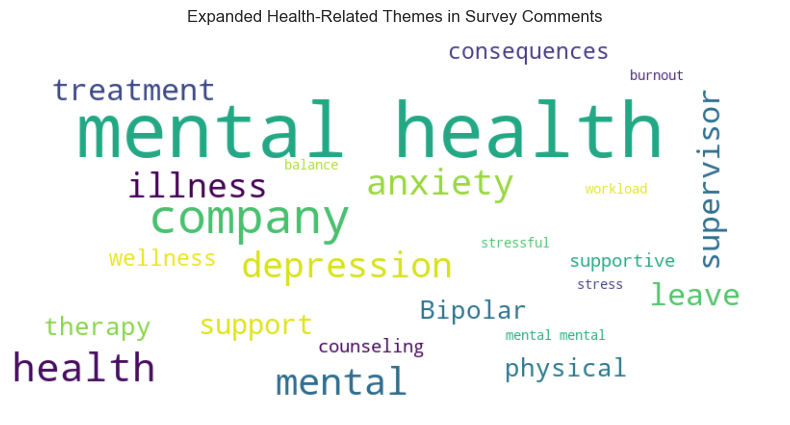

In [424]:
# Expanding the list of health-related keywords to include more relevant terms
expanded_health_keywords = health_keywords + [
    "well-being", "therapy", "counsel", "fatigued", "pressure", "overwork", "mental-health", "treatment", "depression", "bipolar",
    "burnout", "stressful", "workload", "balance", "supportive", "company", "leave", "supervisor", "illnesses", "symptoms", "psychological", "supervisor", "consequences", "neurological problems"
]

# Generate the word cloud using the expanded health-related words only
expanded_health_comment_text = " ".join(word for word in all_words if word.lower() in expanded_health_keywords)

# Create the word cloud for health-related words
wordcloud_expanded_health = WordCloud(width=800, height=400, background_color='white').generate(expanded_health_comment_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_expanded_health, interpolation='bilinear')
plt.axis('off')
plt.title("Expanded Health-Related Themes in Survey Comments")
plt.show()

In [384]:
# Combine and clean all comments into a single string
all_comments = ' '.join(usa_comments_df['comments'].dropna().str.lower())

# Remove punctuation and split text into words
words = re.findall(r'\b\w+\b', all_comments)

# Remove common stopwords and define relevant keywords
stopwords = set(STOPWORDS)
filtered_words = [word for word in words if word not in stopwords]
tts_keywords = ['therapy', 'treatment', 'support']
mental_health_keywords = ['depression', 'anxiety', 'stress'] + ['tts']

# Replace 'therapy', 'treatment', and 'support' with 'tts'
filtered_words = ['tts' if word in tts_keywords else word for word in filtered_words]

# Count the occurrences of relevant mental health words
word_counts = Counter(word for word in filtered_words if word in mental_health_keywords)

# Convert the counts to a DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the results
print(word_counts_df)

         Word  Frequency
2         tts         16
0  depression         13
1     anxiety         11
3      stress          3


C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\1862803879.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


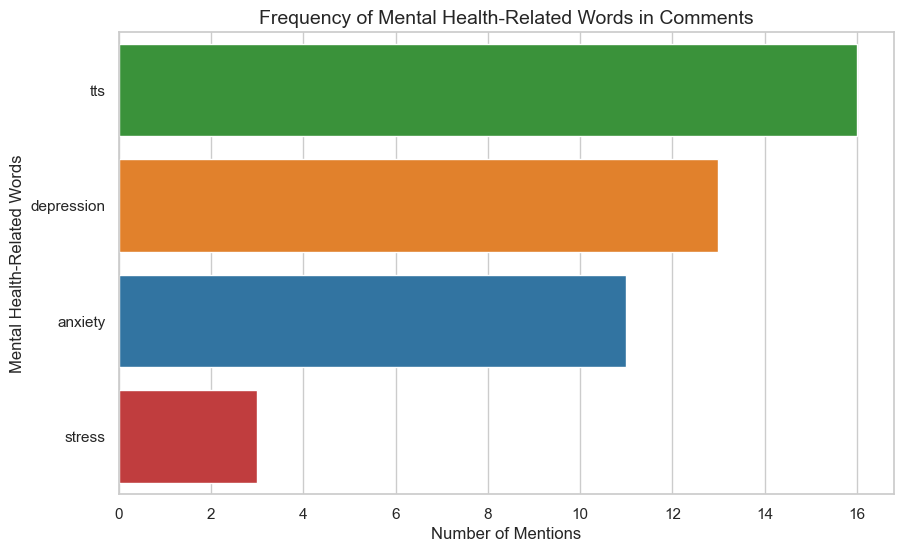

In [418]:
plt.figure(figsize=(10, 6))
category_colors = {
    'tts': '#2ca02c', # Green
    'depression': '#ff7f0e', # Orange
    'anxiety': "#1f77b4", # Blue
    'stress': '#d62728' # Red
}

# Create a custom palette based on the category_colors dictionary
custom_palette = sns.color_palette([category_colors[key] for key in category_colors.keys()])

# Create the horizontal bar chart
bars = sns.barplot(
    x='Frequency',
    y='Word',
    data=word_counts_df,
    palette=custom_palette,
    orient='h'  # Corrected this line
)

# Add labels and title
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('Mental Health-Related Words', fontsize=12)
plt.title('Frequency of Mental Health-Related Words in Comments', fontsize=14)

# Display the plot
plt.show()

In [386]:
# Display all of the comments associated with the mental health categories 
# Define the keywords for the subcategories related to mental health issues
keywords = {
    "anxiety": ["anxiety"],
    "depression": ["depression"],
    "tts": ["therapy", "treatment", "support"]
}

# Create a dictionary to store matching comments
us_theme_data = {key: {"count": 0, "comments": []} for key in keywords}

# Analyze USA-specific comments
for comment in usa_comments_df['comments']:
    comment_lower = comment.lower()
    for theme, terms in keywords.items():
        if any(term in comment_lower for term in terms):
            us_theme_data[theme]["count"] += 1
            us_theme_data[theme]["comments"].append(comment)

# Display the results for anxiety, depression, and tts
anxiety_comments = us_theme_data["anxiety"]["comments"]
depression_comments = us_theme_data["depression"]["comments"]
tts_comments = us_theme_data["tts"]["comments"]

# Print the number of comments and the comments themselves
if anxiety_comments:
    print(f"Anxiety Comments ({len(anxiety_comments)} total):")
    for comment in anxiety_comments[:5]:  # Displaying only first 5 for brevity
        print(comment)
        print("\n")
else:
    print("No comments related to anxiety found.")

if depression_comments:
    print(f"Depression Comments ({len(depression_comments)} total):")
    for comment in depression_comments[:5]:  # Displaying only first 5 for brevity
        print(comment)
        print("\n")
else:
    print("No comments related to depression found.")

if tts_comments:
    print(f"TTS (Therapy, Treatment, Support) Comments ({len(tts_comments)} total):")
    for comment in tts_comments[:5]:  # Displaying only first 5 for brevity
        print(comment)
        print("\n")
else:
    print("No comments related to TTS found.")

Anxiety Comments (8 total):
Family history of depression.  Currently dealing with depression and anxiety as well as drug addition.Employer provides & pays premiums on insurance which covers therapy and prescriptions.  Employer allows work-from-home and unlimited PTO which makes episodes easier to control.I don't speak of my problems to anyone at work except for the people that I consider friends and even then I don't go into great detail.I would never bring up a mental health issue during an interview for fear of discrimination and rejection (and therefore greater depression).  One co-worker had serious anxiety problems and would not inform his team of episodes and was eventually let go for being unresponsive.


The form of mental health problem that I suffer is anxiety.


I mostly suffer from social anxiety which keeps me from attending conferences. In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something so he's doing the

In [388]:
# Copy the relevant data
updated_usa_data = usa_data.copy()

# Create a new column to categorize comments including TTS
updated_usa_data['category'] = updated_usa_data.apply(
    lambda row: (
        'anxiety' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['anxiety']) else
        'depression' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['depression']) else
        'tts' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['tts']) else
        'none'
    ), axis=1
)

# Filter out rows without anxiety, depression, or tts
updated_usa_data_filtered = updated_usa_data[updated_usa_data['category'] != 'none']

# Print the number of rows after filtering and the dataframe
print(f"Number of rows after filtering: {updated_usa_data_filtered.shape[0]}")
updated_usa_data_filtered



Number of rows after filtering: 27


,Age,benefits,leave,seek_help,mental_health_consequence,phys_health_consequence,company_size,remote_work,work_interfere,mental_vs_physical,comments,category
45,38,Yes,Somewhat easy,Yes,No,No,Medium,No,Sometimes,Yes,Our health plan has covered my psychotherapy and my antidepressant medication. My manager has been aware but discreet throughout. I did get negative reviews when my depression was trashing my delivery but y'know I wasn't delivering.,depression
158,25,Don't know,Very easy,No,Maybe,No,Medium,No,Sometimes,Don't know,Family history of depression. Currently dealing with depression and anxiety as well as drug addition.Employer provides & pays premiums on insurance which covers therapy and prescriptions. Employer allows work-from-home and unlimited PTO which makes episodes easier to control.I don't speak of my problems to anyone at work except for the people that I consider friends and even then I don't go into great detail.I would never bring up a mental health issue during an interview for fear of discrimination and rejection (and therefore greater depression). One co-worker had serious anxiety problems and would not inform his team of episodes and was eventually let go for being unresponsive.,anxiety
199,27,Yes,Very easy,No,No,No,Medium,No,Sometimes,Yes,My seniority at the company and rapport with the owners has helped me gain support for seeking help regarding my mental health as well as being able to take time off or work from home when an episode starts.However I don't feel that the company's stance on mental health is as clear as say something like vision or dental. There's very much a stigma.,tts
219,34,Yes,Somewhat easy,No,No,No,Small,No,None,Yes,One of my coworkers has mental health issues and she's open about them (eg: my enjoyment of this project may be due to my recent change in meds). I believe the response has been generally supportive. We're a very small tight-knit company.,tts
287,38,No,Don't know,No,No,Maybe,Small,No,Sometimes,Don't know,The form of mental health problem that I suffer is anxiety.,anxiety
337,24,Yes,Don't know,Don't know,Yes,No,Large,No,None,Don't know,I think there might be some bugs in my thought but I haven't sought treatment because they're not worse than annoying and I worry about having the label.,tts
370,55,Yes,Very easy,Yes,No,No,Large,No,Rarely,Yes,My refer to the mental health issue of depression. I might answer differently if I was talking about a more serious issue like schizophrenia,depression
371,32,Yes,Somewhat easy,Yes,Maybe,No,Medium,No,Sometimes,Yes,My employer does what they can providing a wellness program and pointing it out after particularly stressful times. But the interaction between the wellness program and the medical insurance is unpleasant and finding a long-term therapist / psychiatrist covered by insurance is amazingly difficult. My current lack of active treatment is due to insurance friction more than workplace friction.,tts
450,34,Don't know,Don't know,No,Yes,Yes,Small,No,Sometimes,Don't know,Now at starutp. Previously worked at big tech company which was actually quite good at supporting mental health issues. Still wouldn't share with bosses/other employees though as there remains a strong negative stigma.,tts
510,39,Yes,Very easy,Yes,No,No,Medium,No,Never,Yes,I work for an extremely supportive company and we are amazingly open about mental health issues. Employees often share their struggles with the whole team and receive a high level of support in return.,tts


In [390]:
print(updated_usa_data_filtered['company_size'])

45      Medium
158     Medium
199     Medium
219      Small
287      Small
337      Large
370      Large
371     Medium
450      Small
510     Medium
565      Large
603      Small
607      Small
647      Large
730     Medium
744      Small
795     Medium
838     Medium
845      Large
871      Small
922      Large
1072     Large
1077     Large
1119     Small
1152     Small
1184    Medium
1213     Large
Name: company_size, dtype: object


C:\Users\sunny\AppData\Local\Temp\ipykernel_19408\1309882390.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_usa_data_filtered['company_size'] = pd.Categorical(


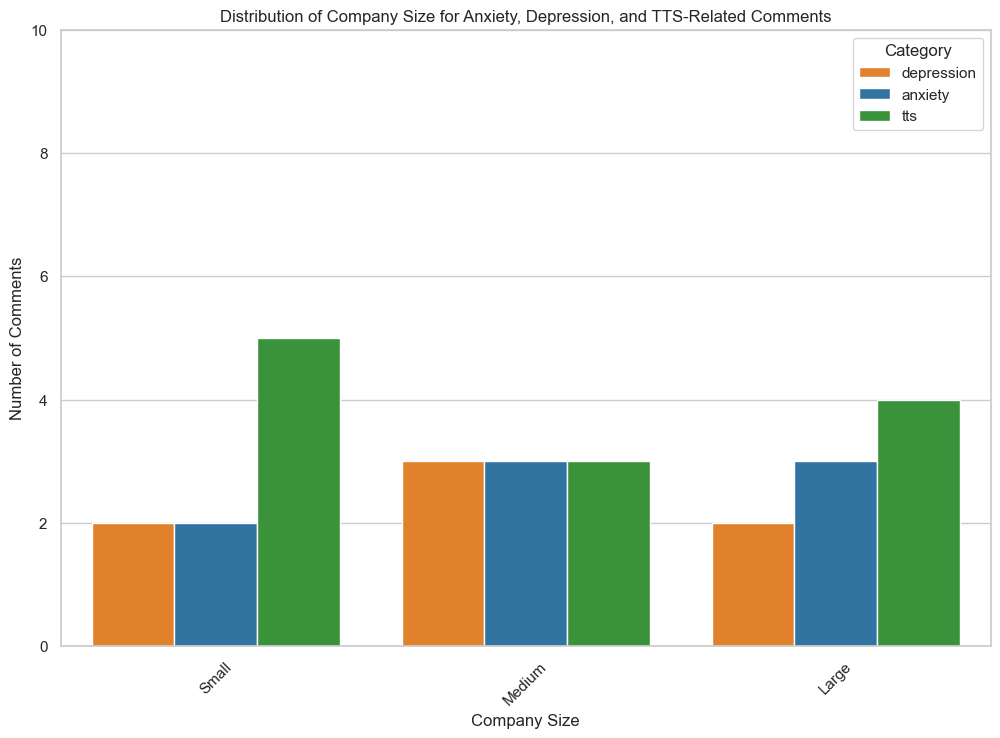

In [421]:
# Ensure that the category names in the data exactly match the keys in the dictionary
category_colors = {
    'tts': '#2ca02c',        # Green
    'depression': '#ff7f0e', # Orange
    'anxiety': "#1f77b4",    # Blue
}

# Create a custom palette based on the category_colors dictionary
# Ensure the palette is generated in the order of the categories in your data
custom_palette = [category_colors[key] for key in updated_usa_data_filtered['category'].unique() if key in category_colors]

# Ensure that the company_size column is treated as a categorical variable with the correct order
updated_usa_data_filtered['company_size'] = pd.Categorical(
    updated_usa_data_filtered['company_size'], 
    categories=['Small', 'Medium', 'Large'],
    ordered=True
)

# Plotting the bar chart for the 'company_size' factor and 'category'
plt.figure(figsize=(12, 8))
sns.countplot(data=updated_usa_data_filtered, x='company_size', hue='category', palette=custom_palette)
plt.title('Distribution of Company Size for Anxiety, Depression, and TTS-Related Comments')
plt.xlabel('Company Size')
plt.ylabel('Number of Comments')
plt.legend(title='Category')
plt.ylim(0, 10)  # Set the y-axis limit as needed
plt.xticks(rotation=45)
plt.show()


In [398]:
# Filter DataFrame to only include Large companies
large_company_df = updated_usa_data_filtered[updated_usa_data_filtered['company_size'].str.contains("Large")]

# Print the filtered comments
print(large_company_df['comments'])

337                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

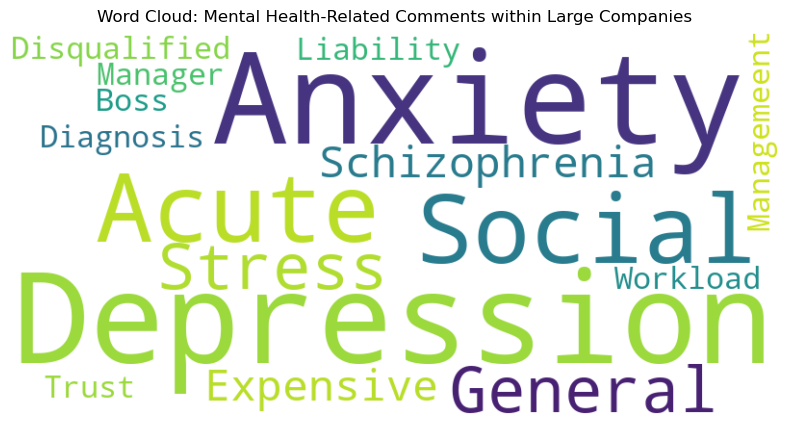

In [399]:
# Text reflecting the specific diagnoses and conditions mentioned
diagnoses_text = """
Depression, Acute Depression, Social Anxiety, General Anxiety, Stress, Schizophrenia, Expensive, Disqualified, Liability, Manager, Boss, Diagnosis, Managemeent, Workload, Trust
"""

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "A", "of", "in", "and", "the", "to", "as", "like", "suggesting", "comparison"
])

# Generate the word cloud focusing on the specific diagnoses
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords,
    max_words=50,
    collocations=False,
    margin=2
).generate(diagnoses_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud: Mental Health-Related Comments within Large Companies")
plt.show()

Sentiment Analysis is conducted using TextBlob which calcualtes the polarity of each comment, giving it a score ranging from -1 (very negative) to +1 (very positive) where 0 is neutral. Additionally, it calculates the subjectivity of the text, which ranges from 0 (completely objective) to 1 (completely subjective). 

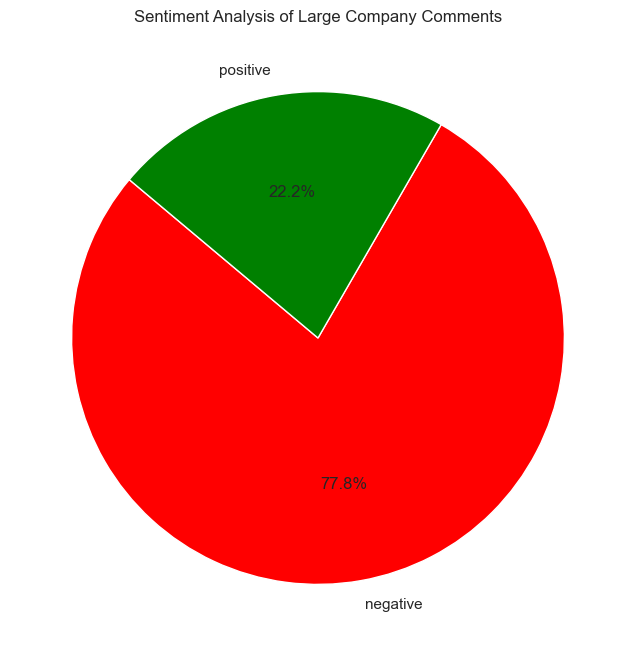

In [423]:
# Conduct a Sentiment Analysis for the comments associated with Mega companies
manual_sentiment_results = [
    {
        'Comment': "I think there might be some bugs in my thought but I haven't sought treatment because they're not worse than annoying and I worry about having the label.",
        'Sentiment': 'negative'  
    },
    {
        'Comment': "My refer to the mental health issue of depression. I might answer differently if I was talking about a more serious issue like schizophrenia.",
        'Sentiment': 'negative' 
    },
    {
        'Comment': "Mental health issue I have dealt with: acute depression.",
        'Sentiment': 'negative'  
    },
    {
        'Comment': "I mostly suffer from social anxiety which keeps me from attending conferences. In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something so he's doing the job of at least two ppl (poorly) and working crazy hours setting the tone for the test of us that work/life balance isn't important.",
        'Sentiment': 'negative'  
    },
    {
        'Comment': "My employer gives access to basic counseling and referrals but I don't know (and it's not obvious) what might be covered in the way of expenses for therapy medication etc.",
        'Sentiment': 'negative' 
    },
    {
        'Comment': "While not personally affected I do have immediate family with mental health illness and my employer has been very supportive. Thanks for doing this survey.",
        'Sentiment': 'positive'  
    },
    {
        'Comment': "I answered based on previous job at large technical company where I was pushed out of my role within 3 months of disclosing diagnosis. I struggled with anxiety caused by stress.",
        'Sentiment': 'negative'  
    },
    {
        'Comment': "This issue for me is very real at the moment. I have missed several days of work recently because of a bad reaction to a depression/anxiety drug and I hate not being able to discuss it with my boss without worrying that I will be labeled a liability.",
        'Sentiment': 'negative'  
    },
    {
        'Comment': "I openly discuss my depression and anxiety struggles. I have found that doing so encourages people who also struggle to seek treatment. I'm willing to risk losing the support of people who don't understand if it helps those who understand all too well.",
        'Sentiment': 'positive'  
    }
]

# Convert to DataFrame
manual_sentiment_df = pd.DataFrame(manual_sentiment_results)

# Count the occurrences of each sentiment
manual_sentiment_counts = manual_sentiment_df['Sentiment'].value_counts()

# Plotting the revised pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    manual_sentiment_counts,
    labels=manual_sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['red', 'green']
)
plt.title('Sentiment Analysis of Large Company Comments')
plt.show()

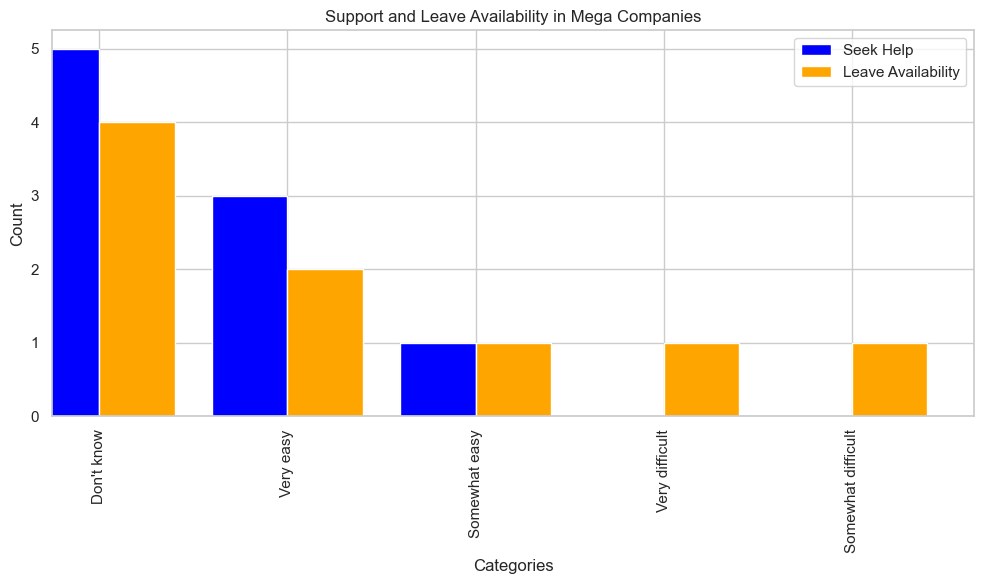

In [422]:
# Create a bar chart to show 'seek_help' and 'leave' distributions within 'Large' comapnies
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'seek_help'
seek_help_counts = large_company_df['seek_help'].value_counts()
seek_help_counts.plot(kind='bar', ax=ax, color='blue', width=0.4, position=1, label='Seek Help')

# Plotting 'leave' next to 'seek_help'
leave_counts = large_company_df['leave'].value_counts()
leave_counts.plot(kind='bar', ax=ax, color='orange', width=0.4, position=0, label='Leave Availability')

# Adding titles and labels
ax.set_title('Support and Leave Availability in Mega Companies')
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
#